### Fake News ✍ Classification

### About Dataset

Link : https://www.kaggle.com/c/fake-news/data

The dataset contains 20800 Rows and 5 columns. The columns present in the dataset are ‘id’,’Article Title’,’Author Name’, ’Article Text’, ‘Label’. The Label column is the target column(Y) and the rest others are independent columns(X). Independent columns are those which will predict the News as Reliable (0) and Non-Reliable (1).

***Categorical Variables:***

- Label: This the Target Variable (Y) where 0 is for Reliable News & 1 is for Fake News

***Numerical & Text Columns:***

- Id: Unique Id for each News Article
- Title: The title of a news article
- Author: Author of the news article
- Text: the text of the article; could be incomplete

***What is Fake News?***

The fundamental definition of fake news is information that leads people wrong. Nowadays, fake news spreads like wildfire, and people share it without confirming it.

#### Importing Libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import os

In [2]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
import re
from autocorrect import Speller
spell = Speller("en")
import contractions
from nltk.stem import WordNetLemmatizer
import emoji
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from nltk import sent_tokenize
from gensim.utils import simple_preprocess
import gensim
import pickle

In [3]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB , MultinomialNB , GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [3]:
!pip install autocorrect
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 15.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=f5cfe485ae69519f998690e03a2c45851f22b2d55e6593834653b0d98a4470d1
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.1 MB/s eta 0:00:00


#### Load Dataset

In [27]:
df = pd.read_csv("train.csv")

In [28]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### Check null values 

In [21]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [22]:
df.dropna(inplace = True)

In [23]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

#### check duplicates values

In [24]:
df.duplicated().sum()

0

#### Plotting the distribution for dataset.

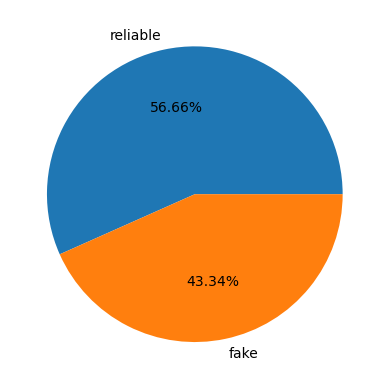

In [27]:
plt.pie(df['label'].value_counts() , labels=["reliable" ,'fake'] , autopct="%0.2f%%")
plt.show()

#### Create new feature called content by adding author and title

In [28]:
df['content'] = df['author']+ " "  +df['title']

In [29]:
df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Consortiumnews.com Why the Truth Might Get You...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Howard Portnoy Iranian woman jailed for fictio...


#### Dropping Unwanted Columns

In [30]:
df1 = df[['content','label']]

## Data Preprocessing
- remove html tags
- Lower case
- Removing all URls
- Removing all @username.
- autocorrection
- Tokenization
- Expand contractions
- Removing special char
- Removing punctution
- wordnetlemmatization
- Demojize
- Removing stop words

In [158]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def text_preprocessing1(text):
    # remove HTML tags
    text = re.sub(re.compile("<.*?>") , '' , text)

    # lower case
    text = text.lower()

    # Removing all URls
    text = re.sub(urlPattern,'',text)

    # Removing all @username.
    text = re.sub(userPattern,'', text)

    # autocorrection
    text = spell(text)
    return text

# df1['preprocess_text'] = df1['content'].apply(text_preprocessing1)

In [159]:
# Expand contractions
def Expand_contractions(text):

    a = []
    for word in text.split():
        a.append(contractions.fix(word))
    text = a[:]
    a.clear()
    return " ".join(text)

# df1['preprocess_text1'] = df1['preprocess_text'].apply(Expand_contractions)

In [166]:
# Removing punctution
def clean_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# df1['preprocess_text2'] = df1['preprocess_text1'].apply(clean_punctuations)

In [160]:
# wordnetlemmatization
def wordnetlemmatizer(text):
    text = word_tokenize(text)

    a = []

    for word in text:
        lem = WordNetLemmatizer()
        a.append(lem.lemmatize(word,pos = "v"))
    text = a[:]
    a.clear()

    return " ".join(text)
# df1['preprocess_text3'] = df1['preprocess_text2'].apply(wordnetlemmatizer)

In [161]:
# Removing special char
def remove_special_char(text):
    text = word_tokenize(text)
    a = []
    for word in text:
        if word.isalnum():
            a.append(word)
    text = a[:]
    a.clear()
    return " ".join(text)
# df1['preprocess_text4'] = df1['preprocess_text3'].apply(remove_special_char)

In [162]:
# demojize
def demojize(text):
    text = emoji.demojize(text)
    text = text.replace(":","")
    return text
# df1['preprocess_text5'] = df1['preprocess_text4'].apply(demojize)
# df1.to_csv("clean_with_stopwords.csv")

In [163]:
# Removing stop words
def remove_stopword(text):
    text = word_tokenize(text)
    a = []
    for word in text:
        if word not in stopwords.words('english'):
            a.append(word)
    text = a[:]
    a.clear()
    return " ".join(text)
# df1['clean_text'] = df1['preprocess_text5'].apply(remove_stopword)
# df1.to_csv("clean_without_stopwords.csv")

In [39]:
df = df1[['clean_text',"label"]]
df.head()

,clean_text,label
0,barrel locus house dem aide even see come lett...,1
1,daniel j flynn flynn hillary clinton big woman...,0
2,consortiumnewscom truth might get fire,1
3,jessica turkish 15 civilians kill single us ai...,1
4,howard portion iranian woman jail fictional un...,1


In [40]:
df.isnull().sum()

clean_text    0
label         0
dtype: int64

### wordcloud for fake News

In [55]:
wc = WordCloud(width=500 , height=500,min_font_size=12 , background_color='white')

In [57]:
fake_wc = wc.generate(df[df['label']==1]['clean_text'].str.cat(sep = " "))

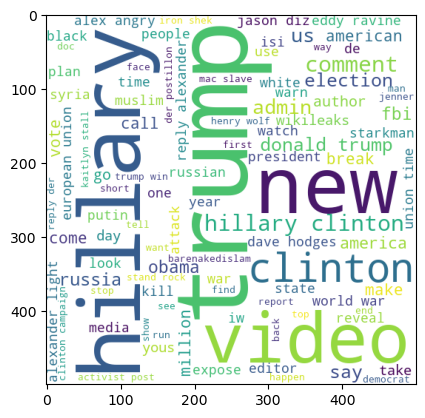

In [58]:
plt.imshow(fake_wc)

### wordcloud for Real News

In [60]:
wc = WordCloud(width=500 , height=500,min_font_size=12 , background_color='white')

In [61]:
real_wc = wc.generate(df[df['label']==0]['clean_text'].str.cat(sep = " "))

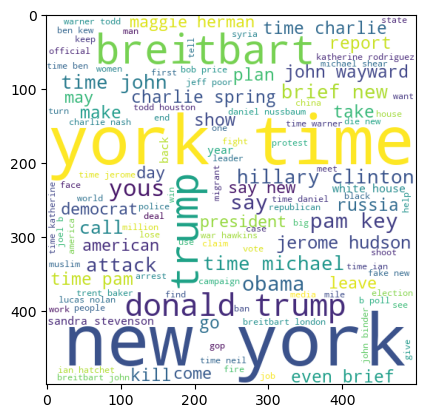

In [62]:
plt.imshow(real_wc)

### let's find top 20 word for fake and real news

In [64]:
fake = []
for msg in df[df['label']==1]['clean_text'].tolist():
    for word in msg.split():
        fake.append(word)

In [65]:
fake_df = pd.DataFrame(Counter(fake).most_common(20))
fake_df.head()

,0,1
0,trump,1182
1,hillary,884
2,clinton,807
3,election,378
4,new,374


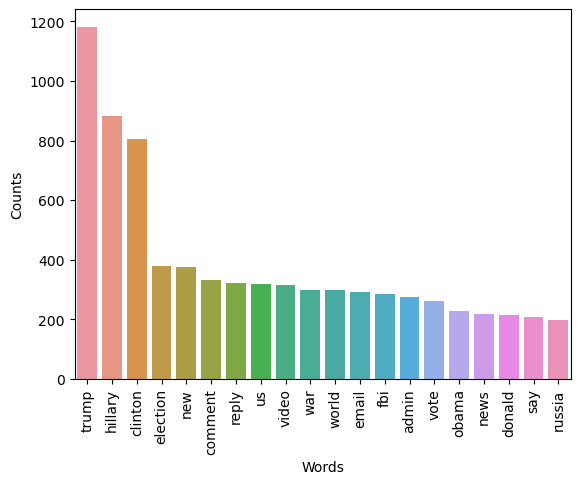

In [66]:
sns.barplot(data=fake_df , x =fake_df[0] , y=fake_df[1])
plt.xticks(rotation = 'vertical')
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()

In [67]:
real = []
for msg in df[df["label"]==0]['clean_text'].tolist():
    for word in msg.split():
        real.append(word)

In [68]:
real_df = pd.DataFrame(Counter(real).most_common(20))
real_df.head()

,0,1
0,new,6697
1,time,6384
2,york,6358
3,breitbart,2751
4,trump,2193


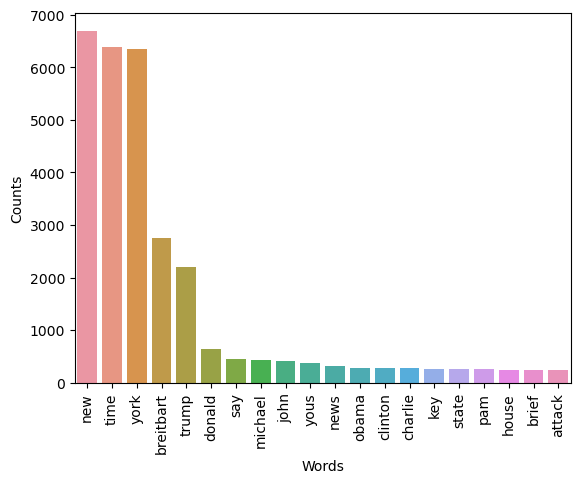

In [69]:
sns.barplot(data=real_df , x =real_df[0] , y=real_df[1])
plt.xticks(rotation = 'vertical')
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()

## Model Building

In [6]:
df = pd.read_csv("clean_without_stopwords.csv")
df = df[['clean_text',"label"]]
df.head()

,clean_text,label
0,barrel locus house dem aide even see come lett...,1
1,daniel j flynn flynn hillary clinton big woman...,0
2,consortiumnewscom truth might get fire,1
3,jessica turkish 15 civilians kill single us ai...,1
4,howard portion iranian woman jail fictional un...,1


#### Converting text to num using word2vec

In [5]:
corpus = []
for doc in df['clean_text']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        
        corpus.append(simple_preprocess(sent))

In [6]:
model = gensim.models.Word2Vec(
    window=4,
    min_count=1,
    sg=1
)

In [7]:
model.build_vocab(corpus)

In [8]:
model.corpus_total_words

196383

In [9]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

(874468, 981915)

In [10]:
# avg word2vec

def document_vector(doc,num_features = 100):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    if doc:    
        return np.mean(model.wv[doc], axis=0)
    else:
        return np.zeros(num_features)

In [11]:
from tqdm import tqdm
X = []
for doc in tqdm(df['clean_text'].values):
    X.append(document_vector(doc))

100%|██████████████████████████████████████████████████████████████████████████| 18285/18285 [00:10<00:00, 1672.92it/s]


In [12]:
y = df['label']

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [14]:
y_train.value_counts()

0    8285
1    6343
Name: label, dtype: int64

In [9]:
accuracy = []
precision = []
recall = []
f1_scores = []
model_name = []

def predict_accuracy(model , X_train ,X_test , y_train ,y_test ):
    for i in range(len(list(model_dict))):
        model = list(model_dict.values())[i]

        model.fit(X_train , y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        # train performance
        train_accuracy_score = accuracy_score(y_train,train_pred)
        train_f1_score = f1_score(y_train,train_pred,average='weighted')
        train_recall_score = recall_score(y_train,train_pred)
        train_precision_score = precision_score(y_train,train_pred)

         # test performance
        test_accuracy_score = accuracy_score(y_test,test_pred)
        test_f1_score = f1_score(y_test,test_pred,average='weighted')
        test_recall_score = recall_score(y_test,test_pred)
        test_precision_score = precision_score(y_test,test_pred)

        print(f"-- {list(model_dict.keys())[i]}")
        print("=============================================================================================================")
        print("--------------------------------------------------TRAIN PERFORMANCE------------------------------------------")
        print("- Accuracy : {:.4f}".format(train_accuracy_score))
        print("- f1_score : {:.4f}".format(train_f1_score))
        print("- recall_score : {:.4f}".format(train_recall_score))
        print("- precision_score : {:.4f}".format(train_precision_score))

        print(" ")
        print("--------------------------------------------------TEST PERFORMANCE------------------------------------------")
        print("- Accuracy : {:.4f}".format(test_accuracy_score))
        print("- f1_score : {:.4f}".format(test_f1_score))
        print("- recall_score : {:.4f}".format(test_recall_score))
        print("- precision_score : {:.4f}".format(test_precision_score))


        print("=============================================================================================================")
        print('\n')

        # plot confusion matrix
        print("--------------------------------------------------Confusion Matrix------------------------------------------")
        cm_test = confusion_matrix(test_pred,y_test)
        dis = ConfusionMatrixDisplay(cm_test,display_labels=["real","fake"])
        dis.plot()
        plt.show()
        print("=============================================================================================================")

        # plot ROC Curve
        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        accuracy.append(test_accuracy_score)
        precision.append(test_precision_score)
        recall.append(test_recall_score)
        f1_scores.append(test_f1_score)
        model_name.append(list(model_dict.keys())[i])

        print("=============================================================================================================")

        # save model
        filename = list(model_dict.keys())[i] + '.pkl'
        import pickle
        pickle.dump(model , open(filename , "wb"))

-- Logistic
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9368
- f1_score : 0.9369
- recall_score : 0.9366
- precision_score : 0.9192
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9371
- f1_score : 0.9371
- recall_score : 0.9330
- precision_score : 0.9225


--------------------------------------------------Confusion Matrix------------------------------------------


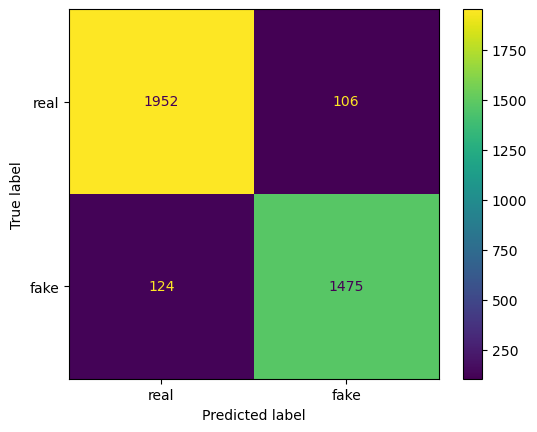

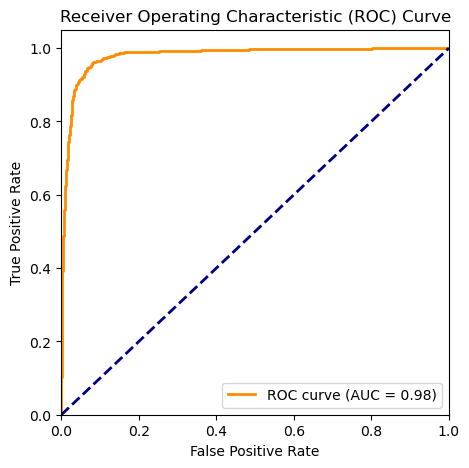

-- bnb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.7915
- f1_score : 0.7920
- recall_score : 0.7818
- precision_score : 0.7485
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.7993
- f1_score : 0.7998
- recall_score : 0.7957
- precision_score : 0.7537


--------------------------------------------------Confusion Matrix------------------------------------------


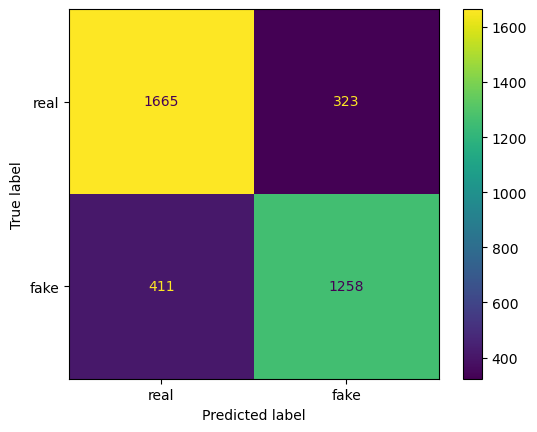

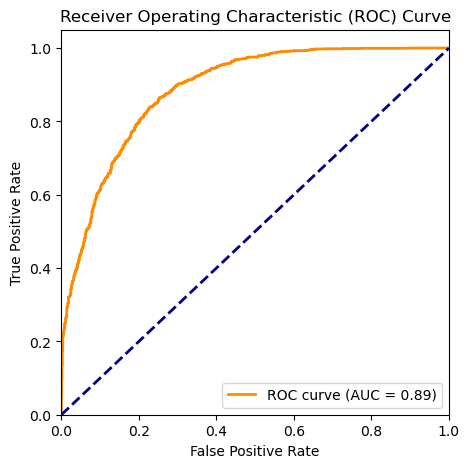

-- gnb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.8558
- f1_score : 0.8561
- recall_score : 0.8564
- precision_score : 0.8192
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.8496
- f1_score : 0.8500
- recall_score : 0.8526
- precision_score : 0.8096


--------------------------------------------------Confusion Matrix------------------------------------------


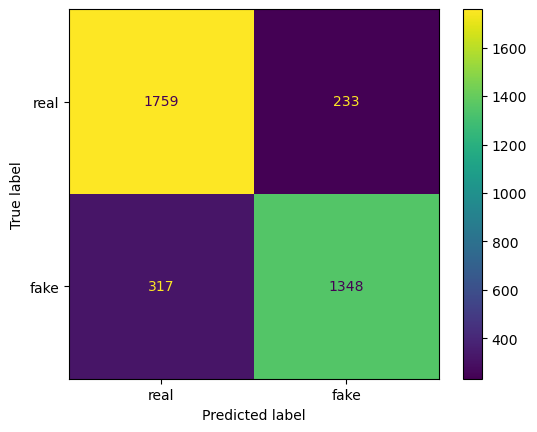

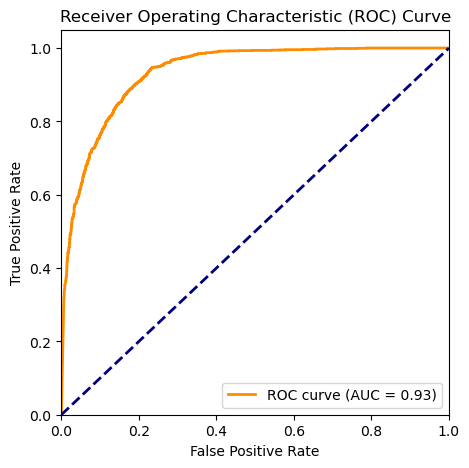

-- Decision_Tree
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9024
- f1_score : 0.9024
- recall_score : 0.8861
- precision_score : 0.8878


--------------------------------------------------Confusion Matrix------------------------------------------


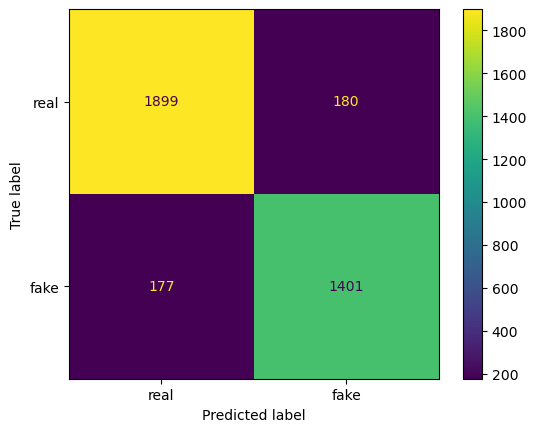

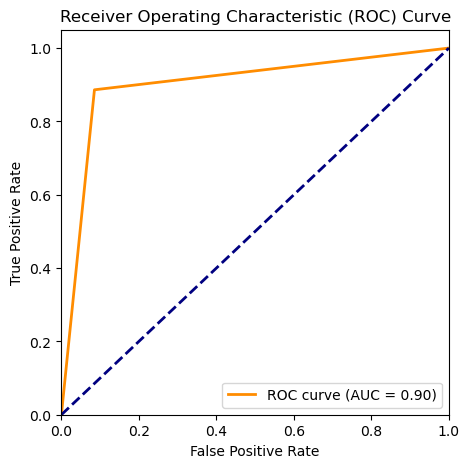

In [18]:
model_dict = {
    'Logistic': LogisticRegression(),
    'bnb' : BernoulliNB(),
#     'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'Decision_Tree': DecisionTreeClassifier()
}
predict_accuracy(model_dict,X_train,X_test,y_train,y_test)

-- RandomForest
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9554
- f1_score : 0.9555
- recall_score : 0.9532
- precision_score : 0.9442


--------------------------------------------------Confusion Matrix------------------------------------------


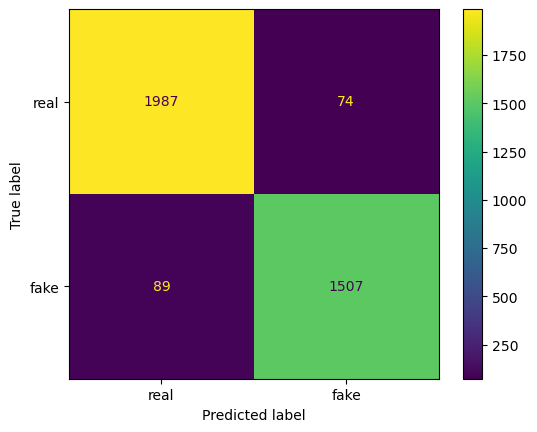

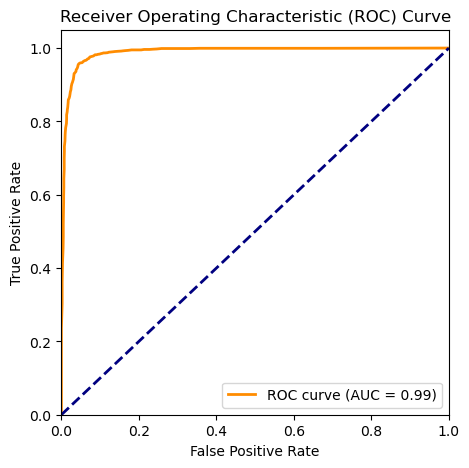

-- Bagging
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9971
- f1_score : 0.9971
- recall_score : 0.9948
- precision_score : 0.9984
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9420
- f1_score : 0.9420
- recall_score : 0.9235
- precision_score : 0.9413


--------------------------------------------------Confusion Matrix------------------------------------------


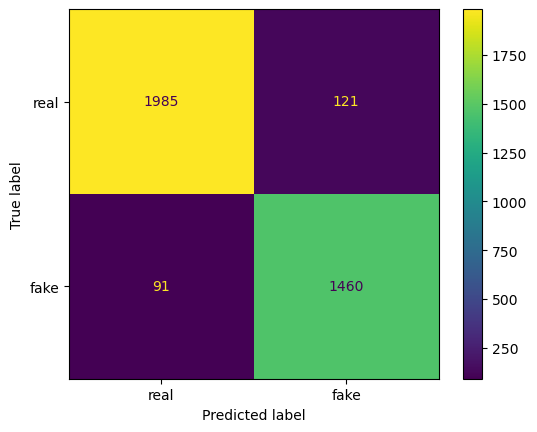

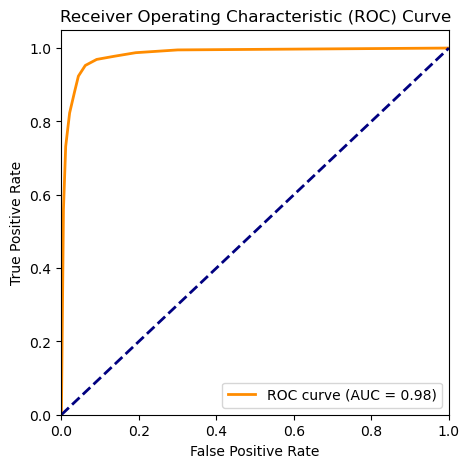

-- Gradient_Boosting
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9551
- f1_score : 0.9551
- recall_score : 0.9555
- precision_score : 0.9417
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9404
- f1_score : 0.9404
- recall_score : 0.9374
- precision_score : 0.9257


--------------------------------------------------Confusion Matrix------------------------------------------


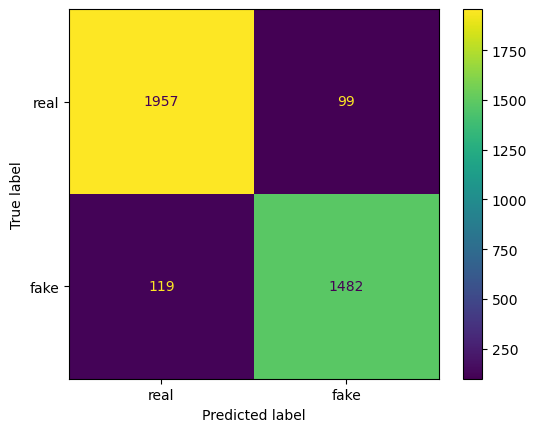

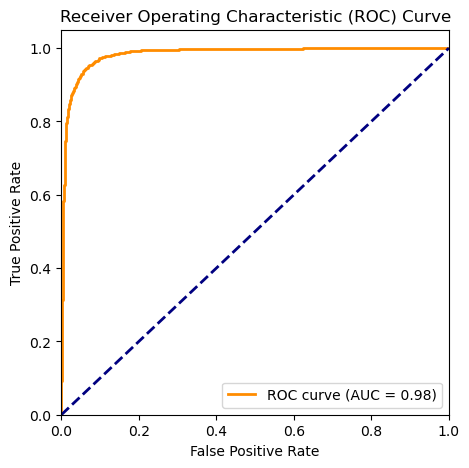

-- XGBOOST
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9628
- f1_score : 0.9628
- recall_score : 0.9639
- precision_score : 0.9507


--------------------------------------------------Confusion Matrix------------------------------------------


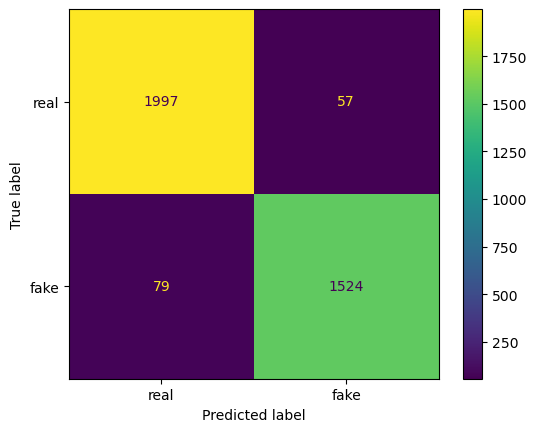

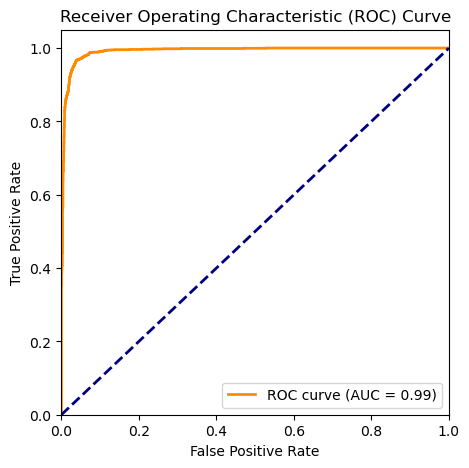

In [19]:
# ensemble technique
model_dict = {
    'RandomForest':RandomForestClassifier(),
    'Bagging':BaggingClassifier(),
    'Gradient_Boosting':GradientBoostingClassifier(),
    'XGBOOST':XGBClassifier()
}
predict_accuracy(model_dict,X_train,X_test,y_train,y_test)

-- SVC
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9519
- f1_score : 0.9520
- recall_score : 0.9663
- precision_score : 0.9261
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9500
- f1_score : 0.9501
- recall_score : 0.9620
- precision_score : 0.9252


--------------------------------------------------Confusion Matrix------------------------------------------


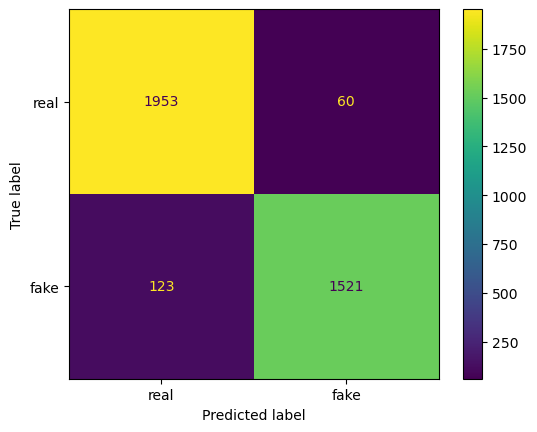

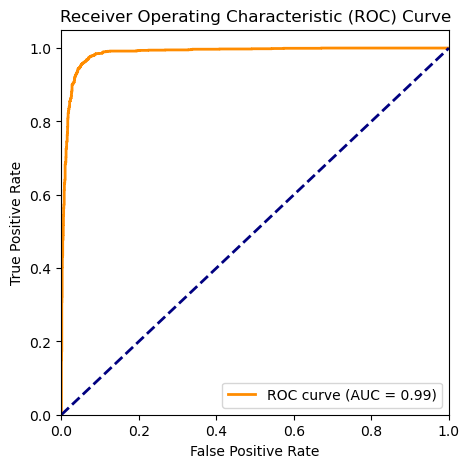

In [21]:
model_dict = {
    'SVC':SVC(probability=True)
}
predict_accuracy(model_dict,X_train,X_test,y_train,y_test)

In [22]:
scores = pd.DataFrame({'model':model_name , 
              "accuracy":accuracy ,
              "precision":precision ,
              "recall":recall,
              "f1_score":f1_scores})
scores

,model,accuracy,precision,recall,f1_score
9,XGBOOST,0.962811,0.950717,0.963947,0.962840
6,RandomForest,0.955428,0.944236,0.953194,0.955452
7,Bagging,0.942029,0.941328,0.923466,0.941959
8,Gradient_Boosting,0.940388,0.925671,0.937381,0.940431
10,SVC,0.949959,0.925182,0.962049,0.950062
0,Logistic,0.937107,0.922452,0.932954,0.937148
2,Logistic,0.937107,0.922452,0.932954,0.937148
5,Decision_Tree,0.902379,0.887833,0.886148,0.902368
4,gnb,0.849604,0.809610,0.852625,0.849997
1,bnb,0.799289,0.753745,0.795699,0.799833


***we got 96.28% of accuracy in XGBOOST.***

In [24]:
import pickle
pickle.dump(scores , open("scores1.pkl","wb"))

#### Hyperparameter tuning using RandomSearchCv

In [31]:
rf_param = {
    'n_estimators':[100,200,300,400,500],
    'max_depth':[2,3,4,5,None],
    'min_samples_split':[1,2,3,4],
    'max_samples':[None,0.2,0.4,0.5,0.7,1]
}

xgb_param = {
    'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.30],
    'max_depth':[3,4,5,6,8,10,12],
    'min_child_weight':[1,3,5,7],
    'gamma':[0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree':[0.3,0.4,0.5,0.6]
}

logistic_param = {
    "penalty":["l1","l2",'elasticnet'],
    "C":[0.8,0.9,1.0],
    "solver" : ['lbfgs', 'liblinear']
}

bagging_param = {
    "n_estimators" : [10,20,50,100],
    "max_samples" : [0.4,0.5,0.7,1.0],
    "max_features" : [0.4,0.5,0.7,1.0],
}

svc_param = {'C': [0.9,0.1, 1, 10, 100],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf','linear','poly']}

In [26]:
model_list = [
    ('RandomForest',RandomForestClassifier(),rf_param),
    ('XGBOOST',XGBClassifier(),xgb_param),
    ("Logistic",LogisticRegression(),logistic_param),
    ("bagging",BaggingClassifier(),bagging_param)
]

In [30]:
model_param = {}
for name , model , param in model_list:
        random = RandomizedSearchCV(model , param_distributions=param,n_jobs=-1,cv=5 , verbose=1)
        random.fit(X_train, y_train)
        
        model_param[name] = random.best_params_
    

for model_name in model_param:
    print("Best param for ",{model_name})
    print(model_param[model_name])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best param for  {'RandomForest'}
{'n_estimators': 100, 'min_samples_split': 1, 'max_samples': 0.7, 'max_depth': None}
Best param for  {'XGBOOST'}
{'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.4}
Best param for  {'Logistic'}
{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
Best param for  {'bagging'}
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.7}


In [32]:
model_list = [
    ('SVC',SVC(),svc_param)
]

In [33]:
model_param = {}
for name , model , param in model_list:
        random = RandomizedSearchCV(model , param_distributions=param,n_jobs=-1,cv=5 , verbose=1)
        random.fit(X_train, y_train)
        
        model_param[name] = random.best_params_
    

for model_name in model_param:
    print("Best param for ",{model_name})
    print(model_param[model_name])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best param for  {'SVC'}
{'kernel': 'poly', 'gamma': 1, 'C': 100}


-- Logistic
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9512
- f1_score : 0.9512
- recall_score : 0.9532
- precision_score : 0.9355
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9500
- f1_score : 0.9500
- recall_score : 0.9551
- precision_score : 0.9309


--------------------------------------------------Confusion Matrix------------------------------------------


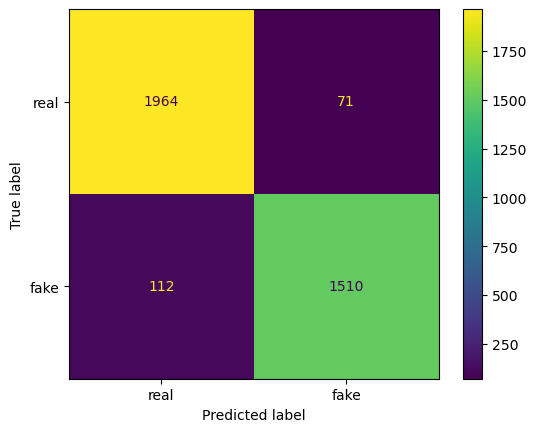

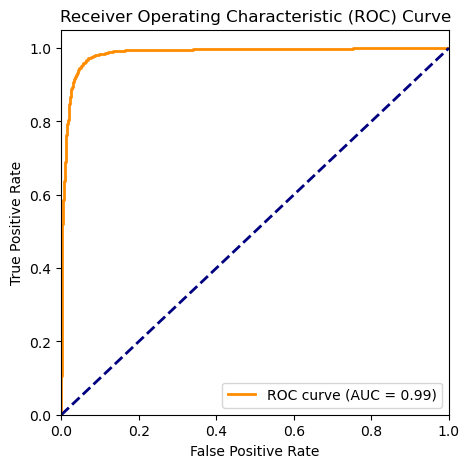

-- RandomForest
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9990
- f1_score : 0.9990
- recall_score : 0.9995
- precision_score : 0.9981
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9519
- f1_score : 0.9519
- recall_score : 0.9475
- precision_score : 0.9415


--------------------------------------------------Confusion Matrix------------------------------------------


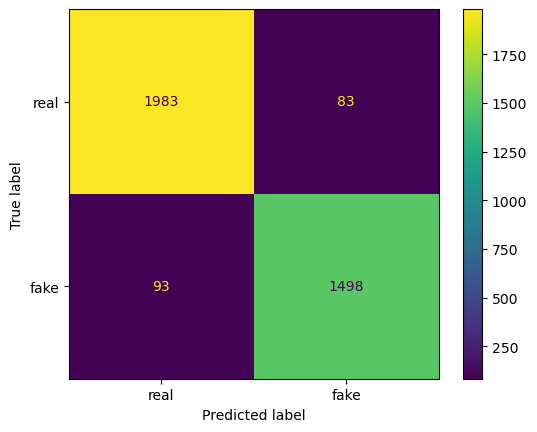

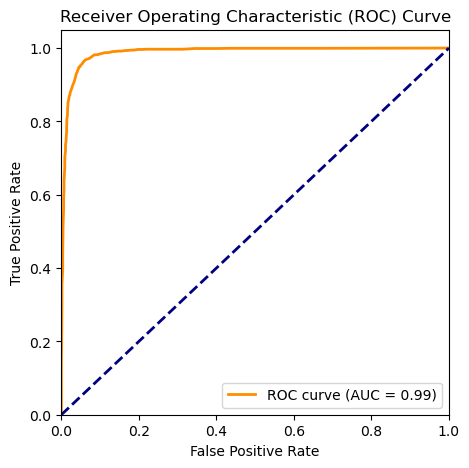

-- XGBOOST
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9636
- f1_score : 0.9637
- recall_score : 0.9646
- precision_score : 0.9519


--------------------------------------------------Confusion Matrix------------------------------------------


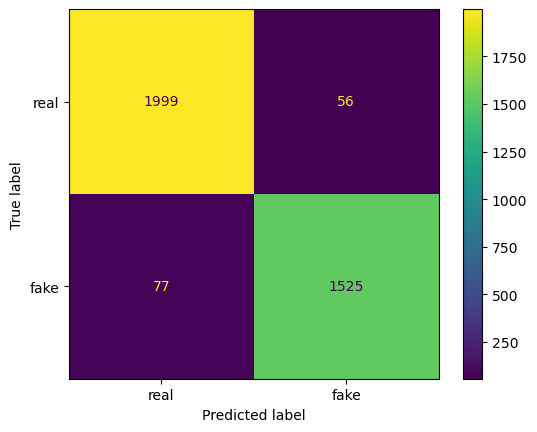

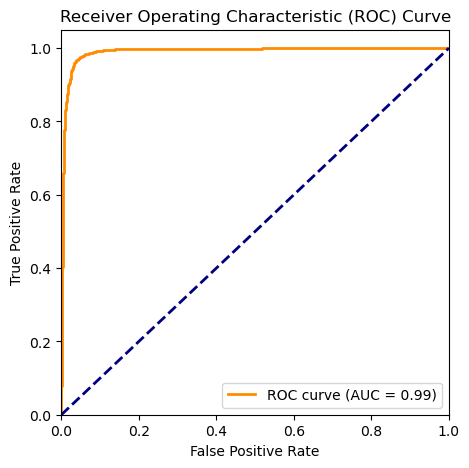

-- Bagging
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9511
- f1_score : 0.9511
- recall_score : 0.9513
- precision_score : 0.9365


--------------------------------------------------Confusion Matrix------------------------------------------


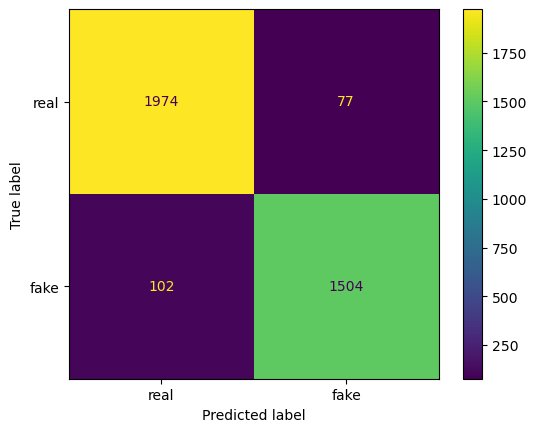

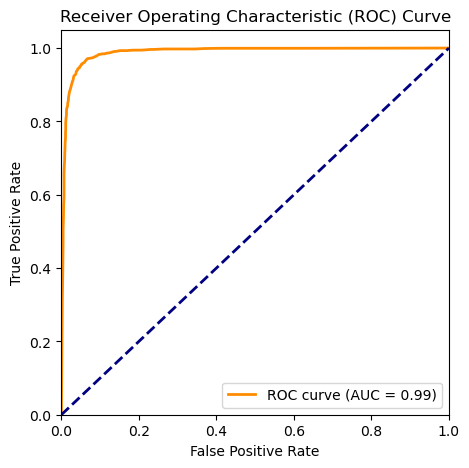

-- SVC
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9939
- f1_score : 0.9939
- recall_score : 0.9975
- precision_score : 0.9886
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9645
- f1_score : 0.9645
- recall_score : 0.9639
- precision_score : 0.9543


--------------------------------------------------Confusion Matrix------------------------------------------


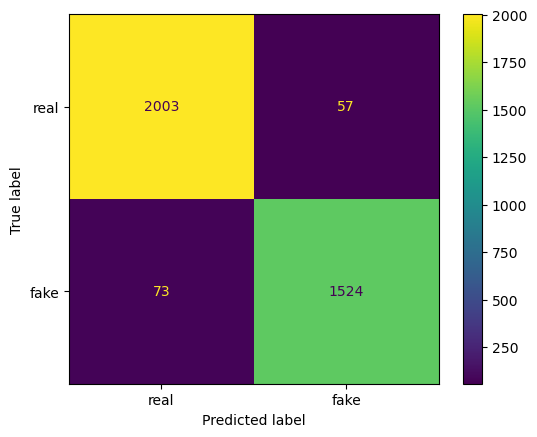

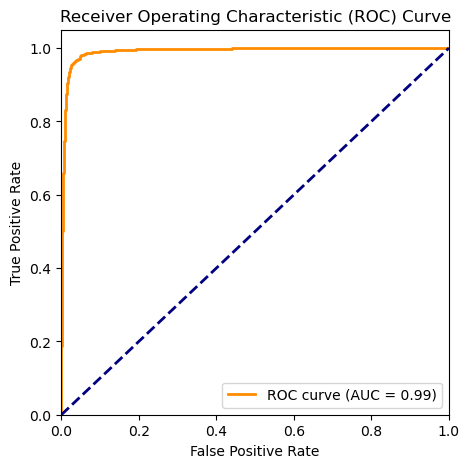

In [39]:
model_dict = {
    'Logistic':LogisticRegression(solver="liblinear",
                                  penalty = "l1",
                                  C = 1.0),

    'RandomForest':RandomForestClassifier(n_estimators=100,
                                          min_samples_split=1,
                                          max_samples=0.7,
                                          max_depth=None),

    'XGBOOST':XGBClassifier(min_child_weight=7,
                            max_depth=12,
                            learning_rate = 0.3,
                            gamma = 0,
                            colsample_bytree = 0.4),

    'Bagging' : BaggingClassifier(n_estimators = 100,
                                  max_samples=1.0,
                                  max_features=0.7),
    "SVC": SVC(kernel="poly",
               gamma=1,
               C=100,
              probability=True)
}

predict_accuracy(model_dict,X_train,X_test,y_train,y_test)


***we got 96.36% of accuracy in XGBOOST and 96.45% in SVM.***

In [40]:
scores2 = pd.DataFrame({'model':model_name , 
                      "accuracy":accuracy ,
                      "precision":precision ,
                      "recall":recall,
                      "f1_score":f1_scores}).sort_values('precision' ,ascending=False)
scores2

,model,accuracy,precision,recall,f1_score
4,SVC,0.964452,0.954289,0.963947,0.964472
2,XGBOOST,0.963631,0.951935,0.964579,0.963659
1,RandomForest,0.951873,0.941546,0.947502,0.951891
3,Bagging,0.951053,0.936488,0.951297,0.951097
0,Logistic,0.949959,0.930949,0.955092,0.950030


### Converting Raw Data Into Matrix for Further Process using Bag of words

In [17]:
X = df['clean_text']
y = df['label']

In [18]:
X_train , X_test , y_train ,y_test = train_test_split(X , y , random_state=23,test_size=0.3)

In [19]:
y_train.value_counts()

0    7263
1    5536
Name: label, dtype: int64

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer()
X_train_cv = CV.fit_transform(X_train).toarray()
X_test_cv = CV.transform(X_test).toarray()

#### 1.Logistic Regression

-- Logistic
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9988
- f1_score : 0.9988
- recall_score : 0.9977
- precision_score : 0.9996
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9861
- f1_score : 0.9862
- recall_score : 0.9899
- precision_score : 0.9785


--------------------------------------------------Confusion Matrix------------------------------------------


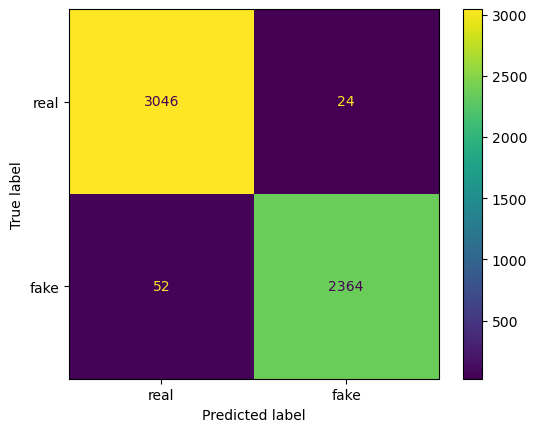

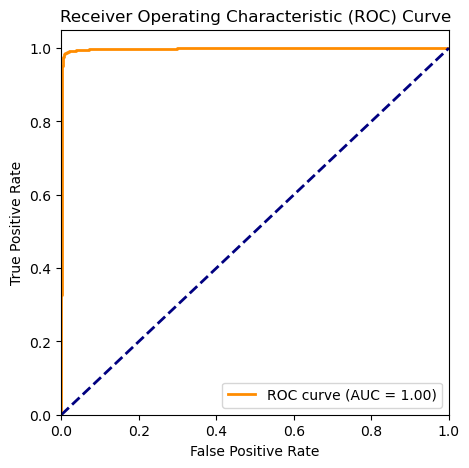

In [46]:
model_dict = {
    'Logistic':LogisticRegression(),
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 2.Bernoulli naive bayes classifier

-- bnb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9907
- f1_score : 0.9907
- recall_score : 0.9904
- precision_score : 0.9881
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9778
- f1_score : 0.9777
- recall_score : 0.9661
- precision_score : 0.9825


--------------------------------------------------Confusion Matrix------------------------------------------


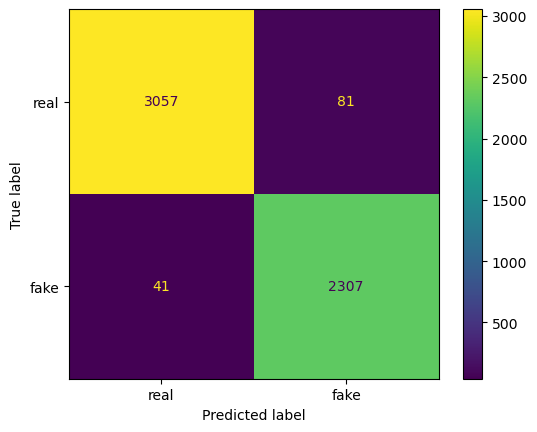

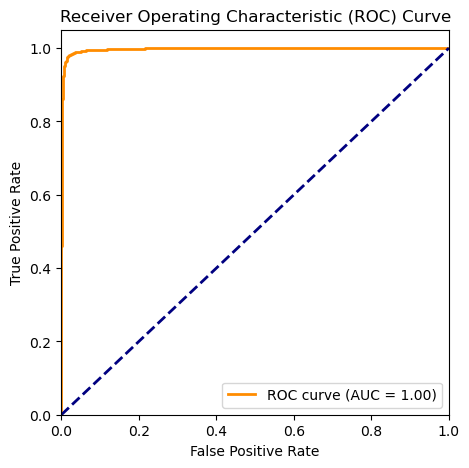

In [47]:
model_dict = {
    'bnb' : BernoulliNB()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 3.Multinomial naive bayes classifier

-- mnb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9880
- f1_score : 0.9880
- recall_score : 0.9756
- precision_score : 0.9967
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9626
- f1_score : 0.9624
- recall_score : 0.9209
- precision_score : 0.9928


--------------------------------------------------Confusion Matrix------------------------------------------


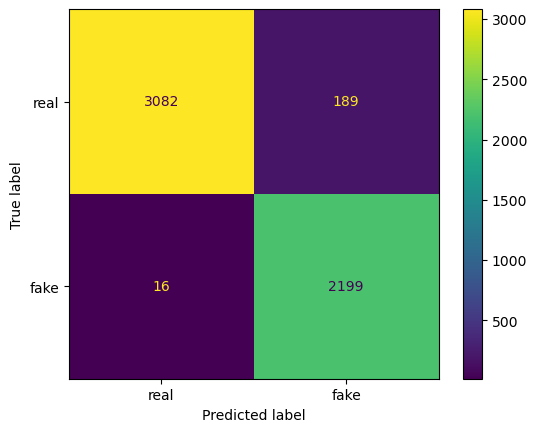

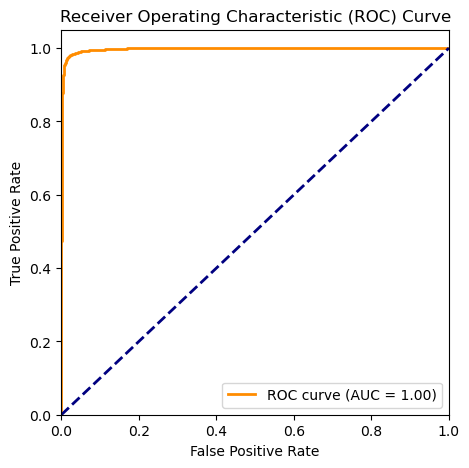

In [48]:
model_dict = {
    'mnb' : MultinomialNB()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 4.Gaussian naive bayes classifier

-- gnb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9637
- f1_score : 0.9639
- recall_score : 0.9987
- precision_score : 0.9237
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.8549
- f1_score : 0.8554
- recall_score : 0.8823
- precision_score : 0.8036


--------------------------------------------------Confusion Matrix------------------------------------------


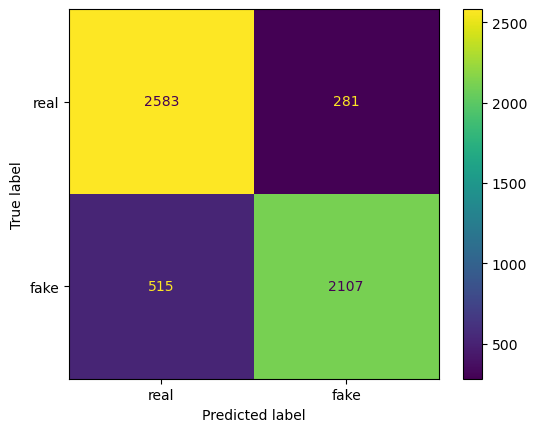

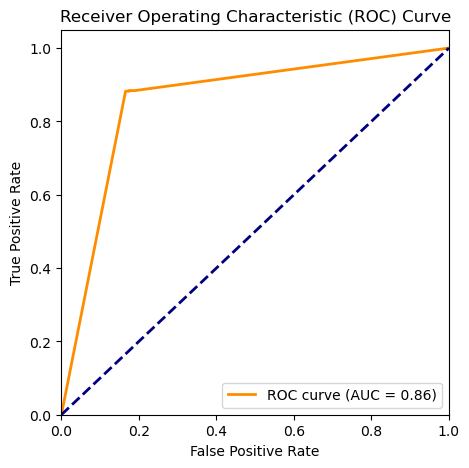

In [49]:
model_dict = {
    'gnb' : GaussianNB()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 5.Support vector machine

-- svm
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9988
- f1_score : 0.9988
- recall_score : 0.9980
- precision_score : 0.9993
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9865
- f1_score : 0.9865
- recall_score : 0.9929
- precision_score : 0.9765


--------------------------------------------------Confusion Matrix------------------------------------------


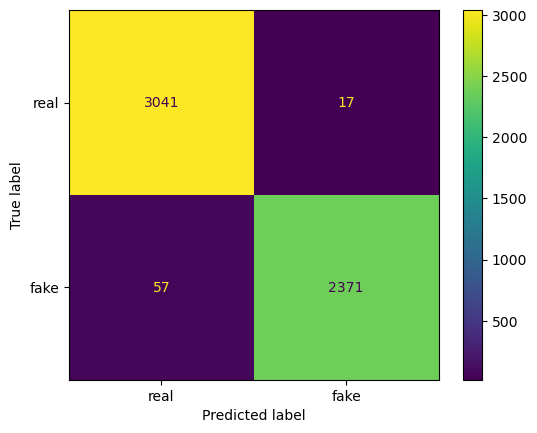

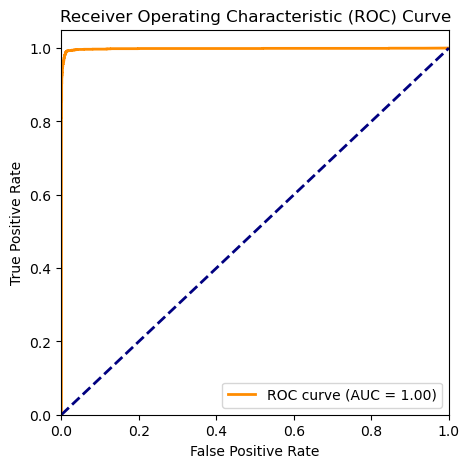

In [50]:
model_dict = {
    'svm' : SVC(probability=True)
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 6.Decision Tree

-- dt
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9885
- f1_score : 0.9885
- recall_score : 0.9862
- precision_score : 0.9874


--------------------------------------------------Confusion Matrix------------------------------------------


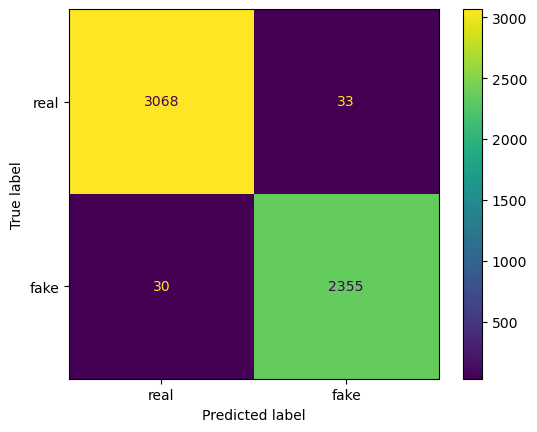

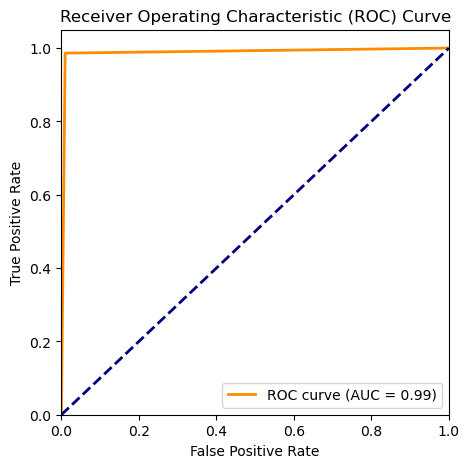

In [51]:
model_dict = {
    'dt' : DecisionTreeClassifier()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

### Ensemble Learning techniques
#### 7.XGBoost

-- xgb
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9919
- f1_score : 0.9919
- recall_score : 0.9986
- precision_score : 0.9829
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9863
- f1_score : 0.9863
- recall_score : 0.9929
- precision_score : 0.9761


--------------------------------------------------Confusion Matrix------------------------------------------


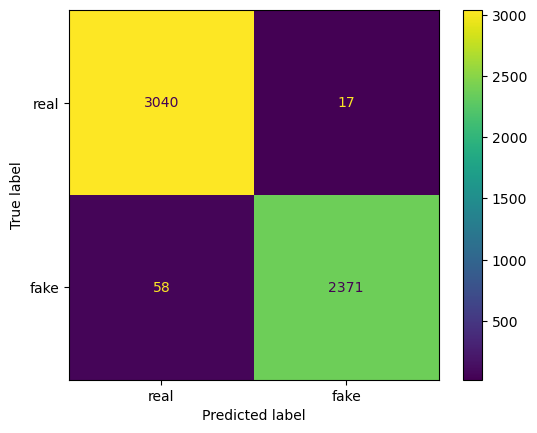

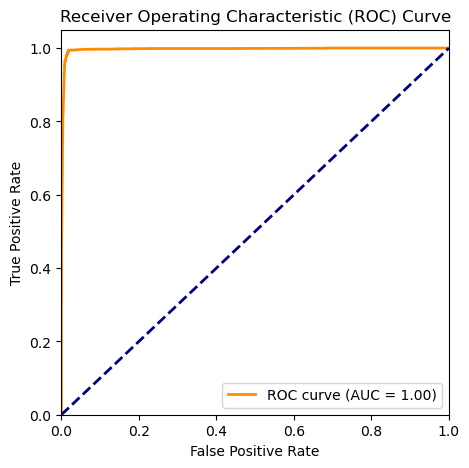

In [52]:
model_dict = {
    'xgb' : XGBClassifier()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 8.BaggingClassifier

-- bg
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9994
- f1_score : 0.9994
- recall_score : 0.9991
- precision_score : 0.9995
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9885
- f1_score : 0.9885
- recall_score : 0.9866
- precision_score : 0.9870


--------------------------------------------------Confusion Matrix------------------------------------------


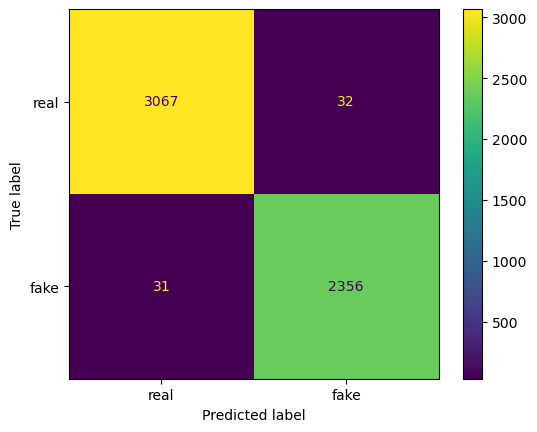

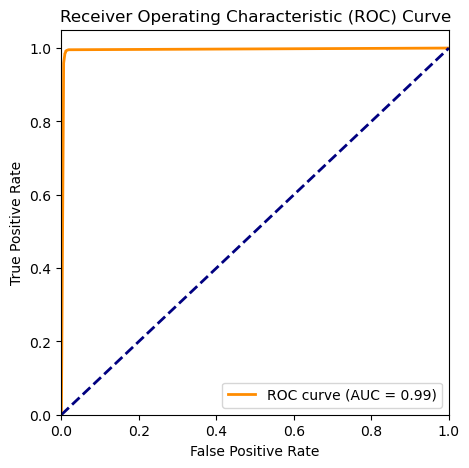

In [53]:
model_dict = {
    'bg' : BaggingClassifier()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

#### 9.RandomForestClassifier

-- rf
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9903
- f1_score : 0.9903
- recall_score : 0.9933
- precision_score : 0.9846


--------------------------------------------------Confusion Matrix------------------------------------------


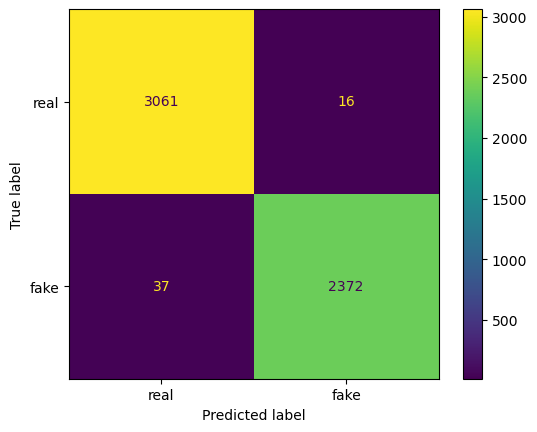

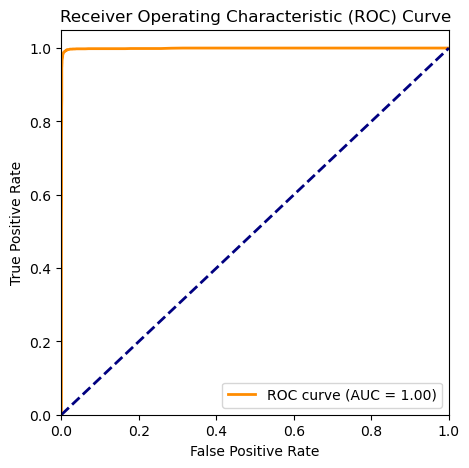

In [54]:
model_dict = {
    "rf" : RandomForestClassifier()
}
predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

In [69]:
scores = pd.DataFrame({'model':model_name , 
              "accuracy":accuracy ,
              "precision":precision ,
              "recall":recall,
              "f1_score":f1_scores})
scores

,index,model,accuracy,precision,recall,f1_score
0,8,rf,0.990339,0.984641,0.993300,0.990344
1,5,dt,0.988516,0.987421,0.986181,0.988515
2,7,bg,0.988516,0.987013,0.986600,0.988516
3,4,svm,0.986511,0.976524,0.992881,0.986523
4,6,xgb,0.986329,0.976122,0.992881,0.986341
5,0,Logistic,0.986147,0.978477,0.989950,0.986155
6,1,bnb,0.977762,0.982538,0.966080,0.977739
7,2,mnb,0.962632,0.992777,0.920854,0.962437
8,3,gnb,0.854903,0.803585,0.882328,0.855444


***we got 99% of accuracy in RandomForest***

In [56]:
pickle.dump(scores , open("scores.pkl","wb"))

#### Hyperparameter tuning using RandomSearchCv

In [57]:
rf_param = {
    'n_estimators':[100,200,300,400,500],
    'max_depth':[2,3,4,5,None],
    'min_samples_split':[1,2,3,4],
    'max_samples':[None,0.2,0.4,0.5,0.7,1]
}

xgb_param = {
    'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.30],
    'max_depth':[3,4,5,6,8,10,12],
    'min_child_weight':[1,3,5,7],
    'gamma':[0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree':[0.3,0.4,0.5,0.6]
}

logistic_param = {
    "penalty":["l1","l2",'elasticnet'],
    "C":[0.8,0.9,1.0],
    "solver" : ['lbfgs', 'liblinear']
}

bagging_param = {
    "n_estimators" : [10,20,50,100],
    "max_samples" : [0.4,0.5,0.7,1.0],
    "max_features" : [0.4,0.5,0.7,1.0],
}

svc_param = {'C': [0.9,0.1, 1, 10, 100],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf','linear','poly']}

In [58]:
model_list = [
    ('RandomForest',RandomForestClassifier(),rf_param),
    ('XGBOOST',XGBClassifier(),xgb_param),
    ("Logistic",LogisticRegression(),logistic_param)
]

In [60]:
model_param = {}
for name , model , param in model_list:
        random = RandomizedSearchCV(model , param_distributions=param,n_jobs=-1,cv=5 , verbose=1)
        random.fit(X_train_cv, y_train)
        
        model_param[name] = random.best_params_
    

for model_name in model_param:
    print("Best param for ",{model_name})
    print(model_param[model_name])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best param for  {'RandomForest'}
{'n_estimators': 300, 'min_samples_split': 1, 'max_samples': 0.5, 'max_depth': None}
Best param for  {'XGBOOST'}
{'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.5}
Best param for  {'Logistic'}
{'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}


In [61]:
model_list = [
    ("bagging",BaggingClassifier(),bagging_param),
#     ('SVC',SVC(),svc_param)
]

model_param = {}
for name , model , param in model_list:
        random = RandomizedSearchCV(model , param_distributions=param,n_jobs=-1,cv=5 , verbose=1)
        random.fit(X_train_cv, y_train)
        
        model_param[name] = random.best_params_
    

for model_name in model_param:
    print("Best param for ",{model_name})
    print(model_param[model_name])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best param for  {'bagging'}
{'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.5}


-- Logistic
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9988
- f1_score : 0.9988
- recall_score : 0.9977
- precision_score : 0.9996
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9863
- f1_score : 0.9863
- recall_score : 0.9899
- precision_score : 0.9789


--------------------------------------------------Confusion Matrix------------------------------------------


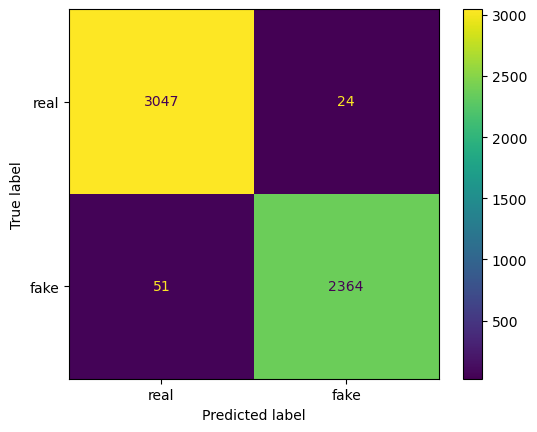

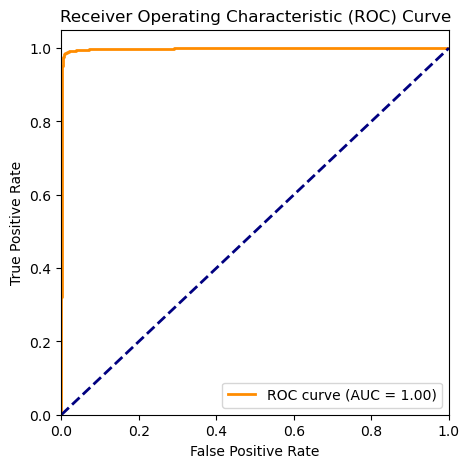

-- RandomForest
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9991
- f1_score : 0.9991
- recall_score : 0.9991
- precision_score : 0.9987
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9891
- f1_score : 0.9891
- recall_score : 0.9933
- precision_score : 0.9818


--------------------------------------------------Confusion Matrix------------------------------------------


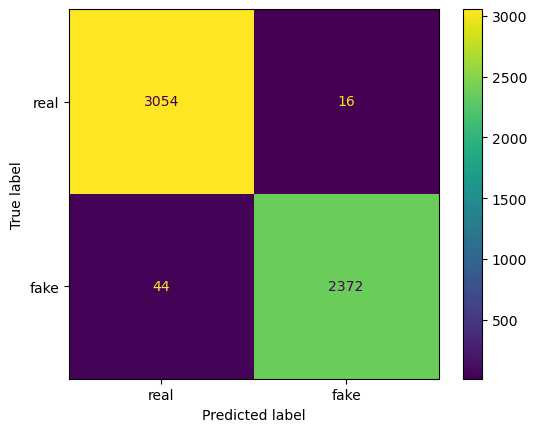

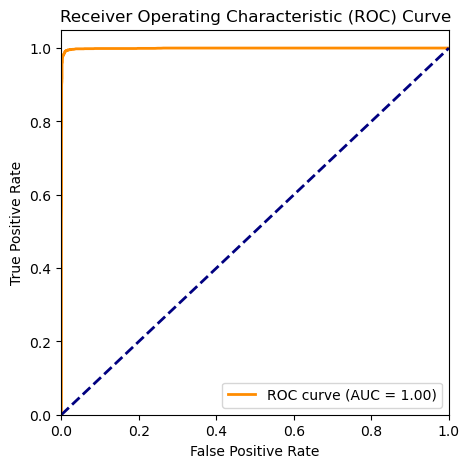

-- XGBOOST
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 0.9914
- f1_score : 0.9914
- recall_score : 0.9975
- precision_score : 0.9829
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9869
- f1_score : 0.9869
- recall_score : 0.9937
- precision_score : 0.9765


--------------------------------------------------Confusion Matrix------------------------------------------


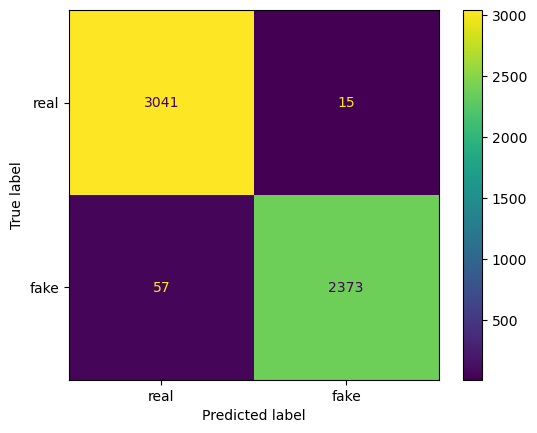

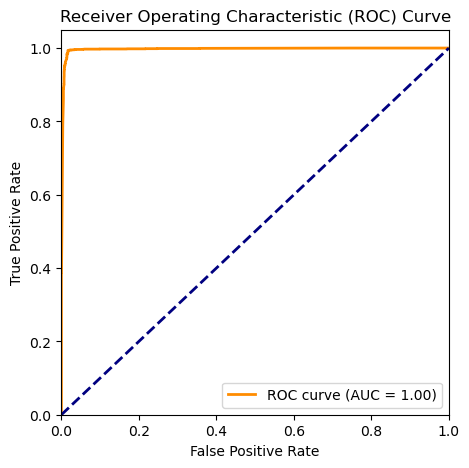

-- Bagging
--------------------------------------------------TRAIN PERFORMANCE------------------------------------------
- Accuracy : 1.0000
- f1_score : 1.0000
- recall_score : 1.0000
- precision_score : 1.0000
 
--------------------------------------------------TEST PERFORMANCE------------------------------------------
- Accuracy : 0.9943
- f1_score : 0.9943
- recall_score : 0.9933
- precision_score : 0.9937


--------------------------------------------------Confusion Matrix------------------------------------------


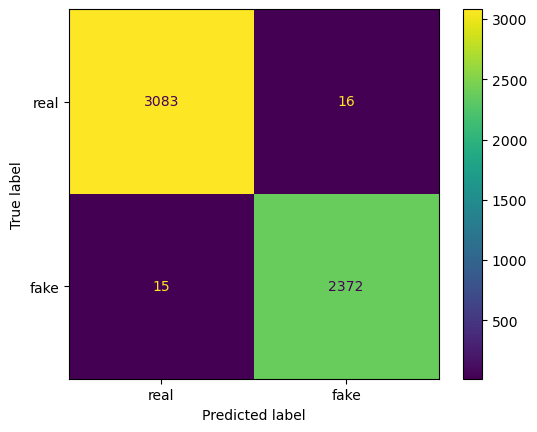

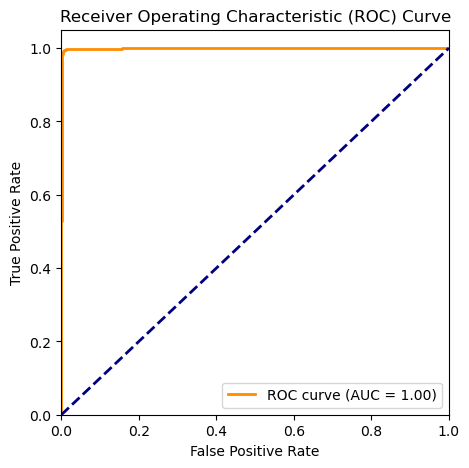

In [ ]:
model_dict = {
    'Logistic':LogisticRegression(solver="liblinear",
                                  penalty = "l2",
                                  C = 1.0),

    'RandomForest':RandomForestClassifier(n_estimators=300,
                                          min_samples_split=1,
                                          max_samples=0.5,
                                          max_depth=None),

    'XGBOOST':XGBClassifier(min_child_weight=1,
                            max_depth=5,
                            learning_rate = 0.3,
                            gamma = 0.2,
                            colsample_bytree = 0.5),

    'Bagging' : BaggingClassifier(n_estimators = 100,
                                  max_samples=1.0,
                                  max_features=0.5),

}

predict_accuracy(model_dict,X_train_cv,X_test_cv,y_train,y_test)

***we got 99.43% of accuracy in Bagging***

## Manual Testing

In [11]:
lr = pickle.load(open("Logistic.pkl","rb"))
mbn = pickle.load(open("BOW_model/mnb.pkl","rb"))
rf = pickle.load(open("RandomForest.pkl","rb"))
xg = pickle.load(open("XGBOOST.pkl","rb"))

In [23]:
def output_lable(n):
    if n==1:
        return "Fake News"
    elif n==0:
        return "Not A Fake News"
    
def testing(news):
    news = {"text":[news]}
    df_test = pd.DataFrame(news)
    df_test['preprocess_text'] = df_test['text'].apply(text_preprocessing1)
    df_test['preprocess_text1'] = df_test['preprocess_text'].apply(Expand_contractions)
    df_test['preprocess_text2'] = df_test['preprocess_text1'].apply(clean_punctuations)
    df_test['preprocess_text3'] = df_test['preprocess_text2'].apply(wordnetlemmatizer)
    df_test['preprocess_text4'] = df_test['preprocess_text3'].apply(remove_special_char)
    df_test['preprocess_text5'] = df_test['preprocess_text4'].apply(demojize)
    df_test['clean_text'] = df_test['preprocess_text5'].apply(remove_stopword)
    new_df = df_test['clean_text']
    
    text_cv = CV.transform(new_df).toarray()
    
    lr_pred = lr.predict(text_cv)
    mbn_pred = mbn.predict(text_cv)
    rf_pred = rf.predict(text_cv)
    xg_pred = xg.predict(text_cv)
    
    return print("\n\nLR Prediction: {} \nMBN Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {} ".format(output_lable(lr_pred[0]),
                                                                                                                                    output_lable(mbn_pred[0]),
                                                                                                                                    output_lable(xg_pred[0]),
                                                                                                                                    output_lable(rf_pred[0])))



In [25]:
news = str(input())
testing(news)

heodore Roosevelt Riding a Moose 


LR Prediction: Fake News 
MBN Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News 


In [35]:
df["title"][26]

'EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart'

In [36]:
df["label"][26]

0

In [31]:
news = str(input())
testing(news)

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It


LR Prediction: Fake News 
MBN Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News 


In [37]:
news = str(input())
testing(news)

EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart


LR Prediction: Not A Fake News 
MBN Prediction: Not A Fake News 
GBC Prediction: Not A Fake News 
RFC Prediction: Not A Fake News 


## Using Deep Learning

In [84]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense,SimpleRNN,Bidirectional
from tensorflow.keras.models import Sequential

In [125]:
# Data preprocessing
X = df['clean_text'].values
y = df['label'].values

In [126]:
X

array(['barrel locus house dem aide even see come letter jason chaffetz tweet',
       'daniel j flynn flynn hillary clinton big woman campus breitbart',
       'consortiumnewscom truth might get fire', ...,
       'michael j de la merge rachel abrams may say receive takeover approach hudson bay new york time',
       'alex angry nato russia hold parallel exercise balkan',
       'david season keep f35 alive'], dtype=object)

In [127]:
# Tokenization and padding
max_features = 15000  # Maximum number of words in your vocabulary
max_len = 100  # Maximum length of a news article

In [128]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)

In [130]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_len)

In [131]:
X

array([[   0,    0,    0, ...,  117, 3911,  652],
       [   0,    0,    0, ...,  180, 1453,    5],
       [   0,    0,    0, ..., 1152,   18,  120],
       ...,
       [   0,    0,    0, ...,    1,    3,    2],
       [   0,    0,    0, ..., 5362, 3007, 6417],
       [   0,    0,    0, ...,  211, 7464, 1912]])

In [132]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
pickle.dump(tokenizer , open("Tokenizer.pkl","wb"))

### 1.RNN

In [109]:
# Build the RNN model
model = Sequential()

# Add an Embedding layer to convert tokenized input to dense vectors
model.add(Embedding(input_dim=max_features,output_dim=20))

# Add an RNN layer with 32 units 
model.add(SimpleRNN(32))

# Add a Dense layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [110]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 20)          3000      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1696      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,729
Trainable params: 4,729
Non-trainable params: 0
_________________________________________________________________


In [112]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
366/366 [==============================] - 8s 20ms/step - loss: 0.2817 - accuracy: 0.8883 - val_loss: 0.1752 - val_accuracy: 0.9313
Epoch 2/10
366/366 [==============================] - 7s 19ms/step - loss: 0.1568 - accuracy: 0.9391 - val_loss: 0.1646 - val_accuracy: 0.9361
Epoch 3/10
366/366 [==============================] - 7s 20ms/step - loss: 0.1445 - accuracy: 0.9427 - val_loss: 0.1628 - val_accuracy: 0.9371
Epoch 4/10
366/366 [==============================] - 7s 19ms/step - loss: 0.1423 - accuracy: 0.9445 - val_loss: 0.1648 - val_accuracy: 0.9378
Epoch 5/10
366/366 [==============================] - 7s 19ms/step - loss: 0.1370 - accuracy: 0.9486 - val_loss: 0.1634 - val_accuracy: 0.9402
Epoch 6/10
366/366 [==============================] - 7s 20ms/step - loss: 0.1348 - accuracy: 0.9486 - val_loss: 0.1653 - val_accuracy: 0.9375
Epoch 7/10
366/366 [==============================] - 7s 20ms/step - loss: 0.1356 - accuracy: 0.9486 - val_loss: 0.1688 - val_accuracy: 0.9402

In [116]:
l , a = model.evaluate(X_test,y_test)
print("loss : {} \naccuracy : {}".format(l,a))

115/115 [==============================] - 1s 7ms/step - loss: 0.1674 - accuracy: 0.9352
loss : 0.1673525869846344 
accuracy : 0.9351927638053894


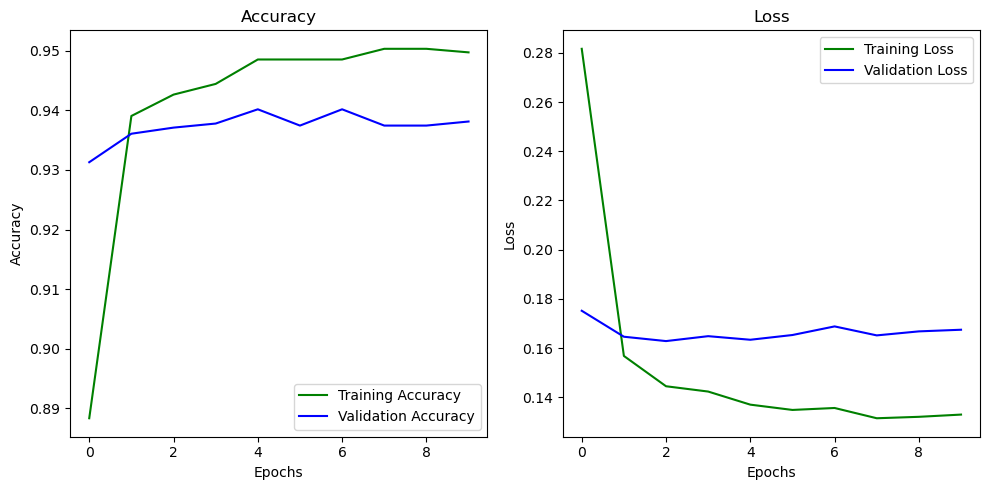

In [113]:
plt.figure(figsize=(10, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="green")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="green")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  
plt.show()

### 2.LSTM

In [133]:
# Build the LSTM model
model = Sequential(name = "LSTM")

# Add an Embedding layer to convert tokenized input to dense vectors
model.add(Embedding(input_dim=max_features,output_dim=64))

# Add an LSTM layer with 64 units 
model.add(LSTM(64))

# Add a Dense layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile 
model.compile(optimizer="adam" , loss = "binary_crossentropy" , metrics = ["accuracy"])

# model summary
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          960000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 993,089
Trainable params: 993,089
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
366/366 [==============================] - 25s 64ms/step - loss: 0.1625 - accuracy: 0.9355 - val_loss: 0.0371 - val_accuracy: 0.9877
Epoch 2/10
366/366 [==============================] - 22s 60ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.0305 - val_accuracy: 0.9915
Epoch 3/10
366/366 [==============================] - 22s 59ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0364 - val_accuracy: 0.9908
Epoch 4/10
366/366 [==============================] - 22s 61ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0397 - val_accuracy: 0.9901
Epoch 5/10
366/366 [==============================] - 22s 60ms/step - loss: 1.5112e-04 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9884
Epoch 6/10
366/366 [==============================] - 22s 60ms/step - loss: 6.6539e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9870
Epoch 7/10
366/366 [==============================] - 22s 60ms/step - loss: 5.4145e-05 - accuracy: 1.0000 - val_loss: 0.0480 - v

In [135]:
l , a = model.evaluate(X_test,y_test)
print("loss : {} \naccuracy : {}".format(l,a))

115/115 [==============================] - 2s 15ms/step - loss: 0.0635 - accuracy: 0.9852
loss : 0.06345069408416748 
accuracy : 0.9852337837219238


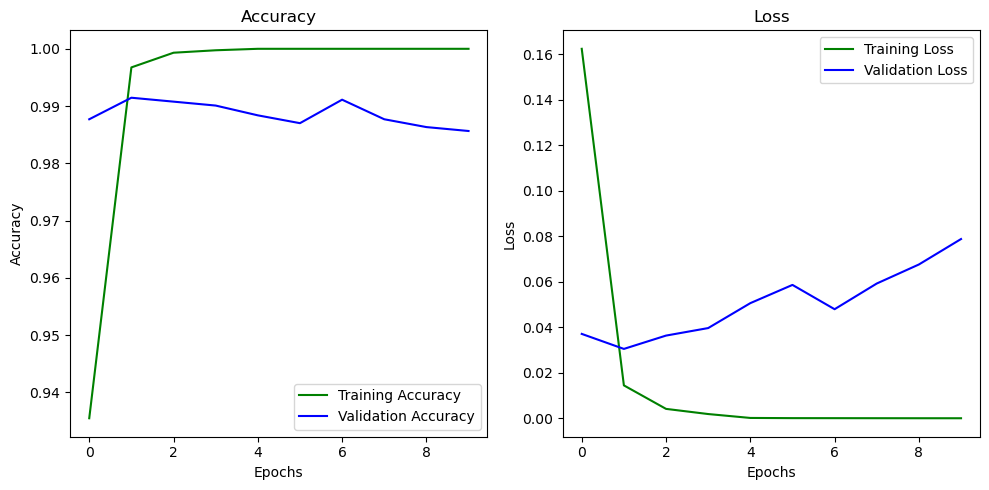

In [136]:
plt.figure(figsize=(10, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="green")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="green")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  
plt.show()

***we got 98.52% of accuracy in LSTM***

In [137]:
model.save("LSTM.h5")

### 3.Bidirectional LSTM

In [138]:
# Build the Bi_di-LSTMmodel
model = Sequential(name = "Bi_di-LSTM")

# Add an Embedding layer to convert tokenized input to dense vectors
model.add(Embedding(input_dim=max_features,output_dim=128))

# Add an Bi_di-LSTM layer with 64 units 
model.add(Bidirectional(LSTM(128)))

# Add a Dense layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile 
model.compile(optimizer="adam" , loss = "binary_crossentropy" , metrics = ["accuracy"])

# model summary
model.summary()

Model: "Bi_di-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         1920000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,183,425
Trainable params: 2,183,425
Non-trainable params: 0
_________________________________________________________________


In [139]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
366/366 [==============================] - 71s 184ms/step - loss: 0.1380 - accuracy: 0.9391 - val_loss: 0.0683 - val_accuracy: 0.9751
Epoch 2/10
366/366 [==============================] - 71s 194ms/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 0.0266 - val_accuracy: 0.9904
Epoch 3/10
366/366 [==============================] - 69s 188ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0302 - val_accuracy: 0.9918
Epoch 4/10
366/366 [==============================] - 70s 190ms/step - loss: 3.8932e-04 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 0.9904
Epoch 5/10
366/366 [==============================] - 69s 189ms/step - loss: 8.4172e-05 - accuracy: 1.0000 - val_loss: 0.0444 - val_accuracy: 0.9901
Epoch 6/10
366/366 [==============================] - 71s 195ms/step - loss: 4.1507e-05 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 0.9880
Epoch 7/10
366/366 [==============================] - 71s 193ms/step - loss: 2.7410e-05 - accuracy: 1.0000 - val_loss:

In [140]:
l , a = model.evaluate(X_test,y_test)
print("loss : {} \naccuracy : {}".format(l,a))

115/115 [==============================] - 4s 38ms/step - loss: 0.0495 - accuracy: 0.9910
loss : 0.04950016364455223 
accuracy : 0.9909762144088745


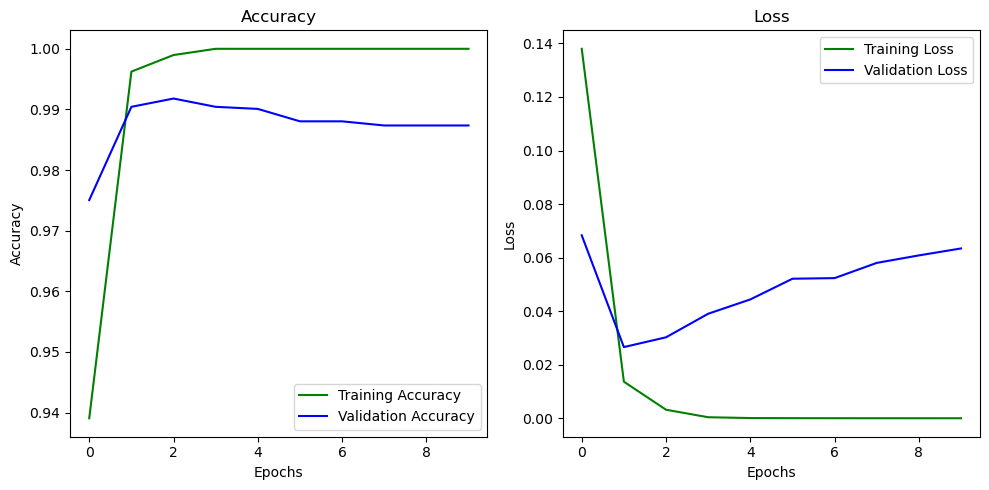

In [141]:
plt.figure(figsize=(10, 5))

#  Accuracy
plt.subplot(1, 2, 1)  
plt.plot(history.history["accuracy"], label="Training Accuracy", c="green")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history["loss"], label="Training Loss", c="green")
plt.plot(history.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  
plt.show()

In [142]:
model.save("Bi_di-LSTM.h5")

***we got 99.09% of accuracy in Bi_di-LSTM***

#### Conclusion:
- we got 99.43% of accuracy when using Bagging which is highest over the all algorithms (Machine learning method)
- we got 99.09% of accuracy when using Bi_di-LSTM (Deep learning method)

#### Improvements:
- Use GridSearchCv for hyperparameter tuning.
- Use pretrained model like Bert.